In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, GlobalAveragePooling1D, LSTM, Bidirectional, Dropout, Reshape, Lambda)
from tensorflow.keras.optimizers import Adam
from transformers import TFSwinModel, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix
from tkinter import filedialog, Tk  
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops  
import matplotlib.patches as patches  

/Users/kshitijchaudhary/miniforge3/envs/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Mixed Precision for Swin Transformer
tf.keras.mixed_precision.set_global_policy('float32')

# TensorFlow and GPU Configuration
print("TensorFlow version:", tf.__version__)
print("Transformers version:", TFSwinModel.__module__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.13.0
Transformers version: transformers.models.swin.modeling_tf_swin
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Data Directories
data_dir = 'Desktop/Dataset/corn'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')



In [4]:
# Loading Swin Transformer Model
print("Loading Swin Transformer Model...")
swin_model = TFSwinModel.from_pretrained('microsoft/swin-tiny-patch4-window7-224')
image_processor = AutoImageProcessor.from_pretrained('microsoft/swin-tiny-patch4-window7-224')
print("Swin Transformer Model Loaded Successfully!")



Loading Swin Transformer Model...


2025-02-24 10:46:00.157074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-24 10:46:00.157550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFSwinModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSwinModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSwinModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinModel for predictions without further training.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a s

Swin Transformer Model Loaded Successfully!


In [5]:
#Image Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10832 images belonging to 4 classes.
Found 210 images belonging to 4 classes.
Found 1315 images belonging to 4 classes.


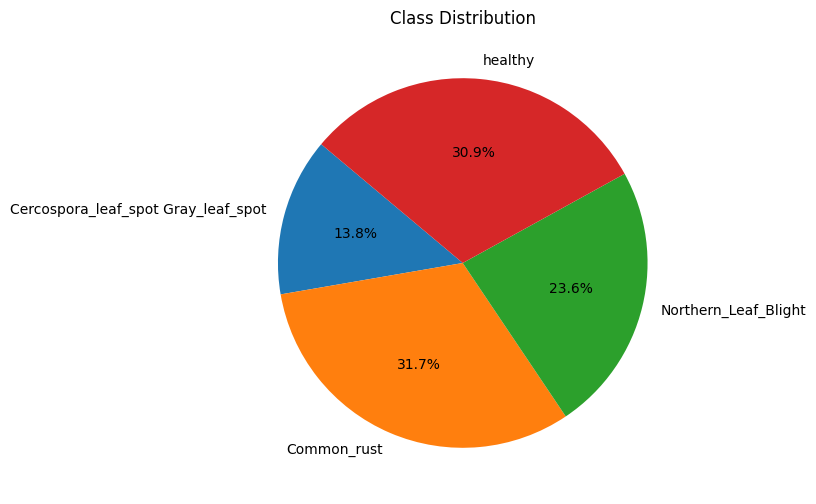

In [6]:
# Class labels
class_labels = list(train_data.class_indices.keys())

# Plot class distribution
class_counts = train_data.classes  
unique, counts = np.unique(class_counts, return_counts=True)  

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()




In [7]:

# Model Architecture
input_layer = Input(shape=(224, 224, 3))
float32_layer = Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)

# Reshape input to match Swin Transformer requirements
reshaped_layer = Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]))(float32_layer)

# Extract features using Swin Transformer
swin_features = swin_model(reshaped_layer).last_hidden_state

# Global Pooling + BiLSTM Layers
global_pooling = GlobalAveragePooling1D()(swin_features)
reshape_layer = Reshape((1, -1))(global_pooling)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=False))(reshape_layer)
dropout_layer = Dropout(0.5)(bilstm_layer)
output_layer = Dense(len(class_labels), activation='softmax')(dropout_layer)


In [8]:

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Train Model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10


2025-02-24 10:46:28.210428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:46:34.955105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:46:34.966789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:46:35.164080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:46:35.180002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8876

2025-02-24 10:52:38.930255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:52:45.538557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 10:52:45.549537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 392s 1s/step - loss: 0.3319 - accuracy: 0.8876 - val_loss: 0.1512 - val_accuracy: 0.9619
Epoch 2/10
339/339 [==============================] - 346s 1s/step - loss: 0.0891 - accuracy: 0.9722 - val_loss: 0.0728 - val_accuracy: 0.9667
Epoch 3/10
339/339 [==============================] - 344s 1s/step - loss: 0.0676 - accuracy: 0.9798 - val_loss: 0.0696 - val_accuracy: 0.9857
Epoch 4/10
339/339 [==============================] - 348s 1s/step - loss: 0.0518 - accuracy: 0.9832 - val_loss: 0.2318 - val_accuracy: 0.8905
Epoch 5/10
339/339 [==============================] - 354s 1s/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.0470 - val_accuracy: 0.9762
Epoch 6/10
339/339 [==============================] - 351s 1s/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.0218 - val_accuracy: 0.9952
Epoch 7/10
339/339 [==============================] - 357s 1s/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.0779 - val_accuracy: 0.9667
Epoch 8/10

In [10]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

42/42 [==============================] - 19s 446ms/step - loss: 0.0479 - accuracy: 0.9833
Test Accuracy: 98.33%


In [11]:
# Predict on Test Data
test_predictions = model.predict(test_data)
test_labels = test_data.classes
test_pred_classes = np.argmax(test_predictions, axis=-1)


2025-02-24 11:40:10.044479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/42 [..............................] - ETA: 7:10

2025-02-24 11:40:16.725273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 11:40:16.734284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 28s 425ms/step



Classification Report:

                                     precision    recall  f1-score   support

Cercospora_leaf_spot Gray_leaf_spot       0.90      0.94      0.92       134
                        Common_rust       1.00      1.00      1.00       364
               Northern_Leaf_Blight       0.98      0.97      0.98       484
                            healthy       1.00      1.00      1.00       333

                           accuracy                           0.98      1315
                          macro avg       0.97      0.98      0.97      1315
                       weighted avg       0.98      0.98      0.98      1315



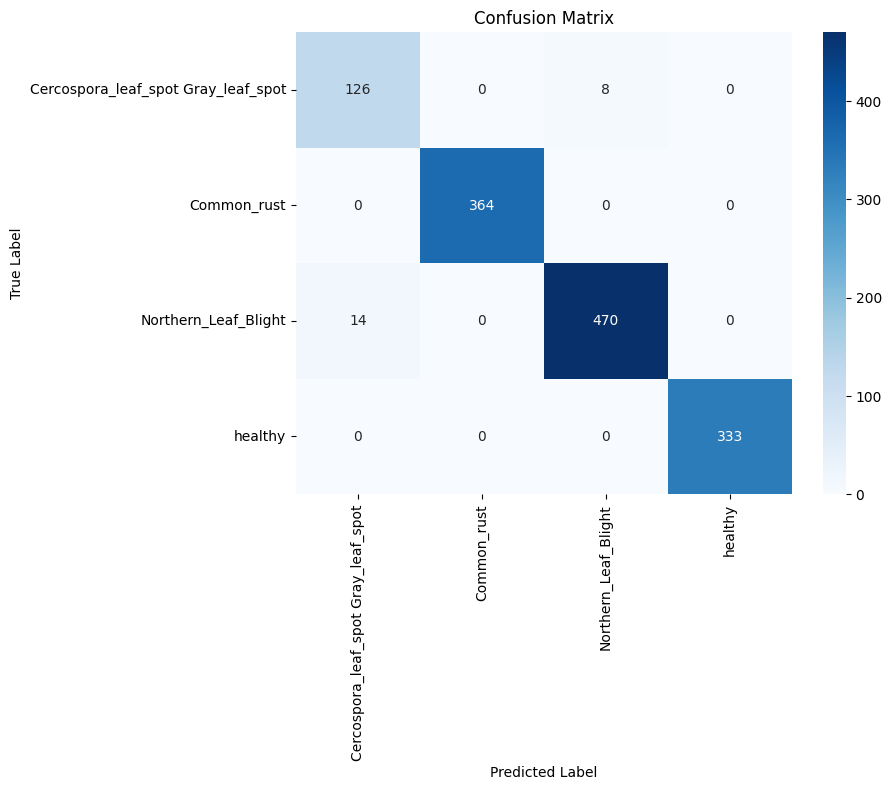

In [12]:
# Classification Report and Confusion Matrix
print("\nClassification Report:\n")
print(classification_report(test_labels, test_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(test_labels, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


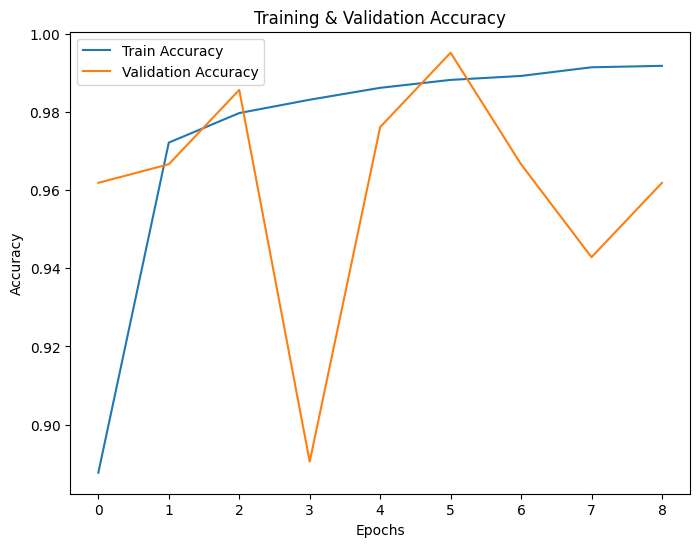

In [13]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

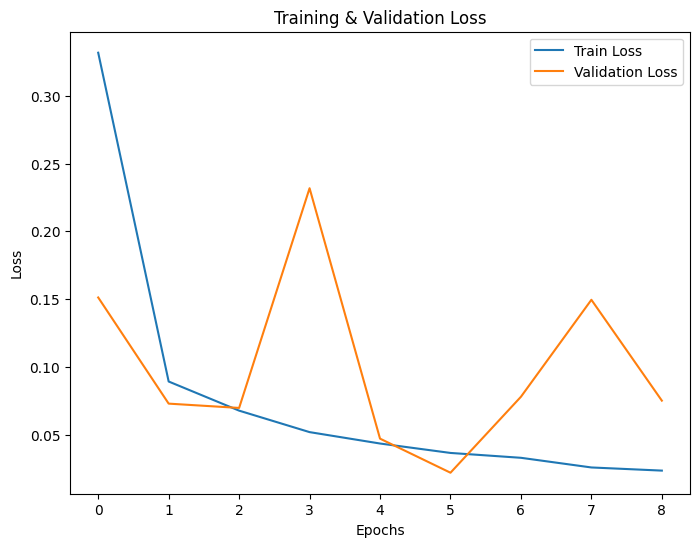

In [14]:
# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


2025-02-24 11:44:02.798 python[2320:33486] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-24 11:44:03.395 python[2320:33486] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


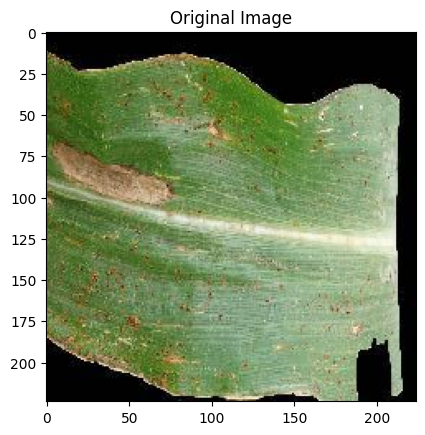

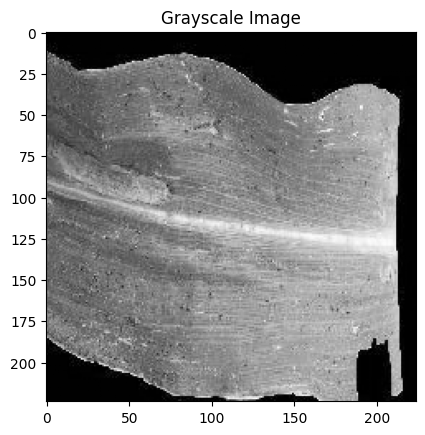

/Users/kshitijchaudhary/miniforge3/envs/tf_env/lib/python3.10/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/Users/kshitijchaudhary/miniforge3/envs/tf_env/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/Users/kshitijchaudhary/miniforge3/envs/tf_env/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/Users/kshitijchaudhary/miniforge3/envs/tf_env/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will

GLCM Features:
Contrast: 499.3656910634209
Dissimilarity: 11.689401825752723
Homogeneity: 0.23415142736327196


2025-02-24 11:44:39.207067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step


2025-02-24 11:44:44.711611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-24 11:44:44.720875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted disease: Common_rust
1/1 [==============================] - 0s 170ms/step
Predicted disease: Common_rust


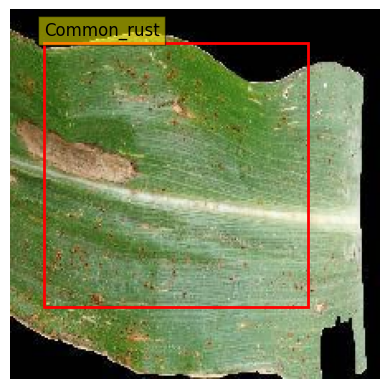

In [15]:


# Upload and Predict Image from Local System
def upload_and_predict_local_image():
    # Open file dialog for selecting an image
    Tk().withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(title='Select an Image for Prediction')

    if file_path:
        img = load_img(file_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title('Original Image')
        plt.show()

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.0  # Normalize the image

        # GLCM Feature Extraction
        gray_img = rgb2gray(x[0])
        plt.imshow(gray_img, cmap='gray')
        plt.title('Grayscale Image')
        plt.show()

        glcm = greycomatrix((gray_img * 255).astype('uint8'), [1], [0], symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]

        # Display GLCM Features
        print("GLCM Features:")
        print(f"Contrast: {contrast}")
        print(f"Dissimilarity: {dissimilarity}")
        print(f"Homogeneity: {homogeneity}")

        # Predict the class
        classes = model.predict(x, batch_size=10)
        predicted_label = class_labels[np.argmax(classes[0])]
        print("Predicted disease:", predicted_label)

        # Predict and Visualize Bounding Box
        y_pred = model.predict(x)
        predicted_disease = class_labels[np.argmax(y_pred[0])]
        print("Predicted disease:", predicted_disease)

        # Dummy Bounding Box (Replace with actual coordinates if available)
        bounding_box = [20, 20, 180, 180]

        # Create the plot
        fig, ax = plt.subplots()
        ax.imshow(img)

        # Create a bounding box rectangle
        rect = patches.Rectangle((bounding_box[0], bounding_box[1]),
                                 bounding_box[2] - bounding_box[0],
                                 bounding_box[3] - bounding_box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')

        # Add the bounding box to the plot
        ax.add_patch(rect)

        # Label the bounding box with the predicted disease
        ax.text(bounding_box[0], bounding_box[1] - 5, predicted_disease,
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12)

        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print("No file was selected.")

# Run Image Upload and Prediction Function
upload_and_predict_local_image()

2025-02-24 11:44:50.493 python[2320:33486] +[IMKInputSession subclass]: chose IMKInputSession_Modern


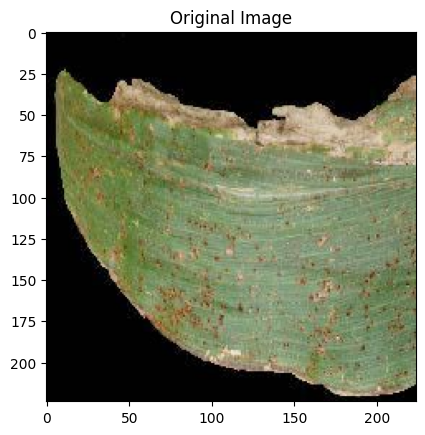

1/1 [==============================] - 0s 179ms/step
Prediction Probabilities: [3.3081672e-04 9.9906558e-01 2.8229010e-04 3.2134051e-04]
Predicted disease: Common_rust
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
1/1 [==============================] - 0s 126ms/step
Predicted disease: Common_rust


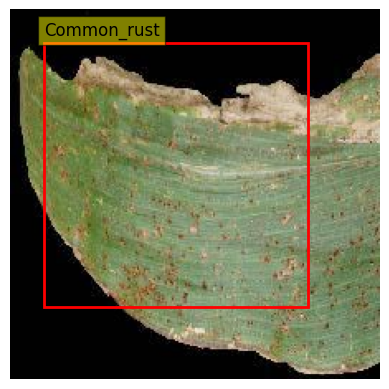

In [16]:
# Function for Local Image Upload and Prediction
def upload_and_predict():
    # Open file dialog for selecting an image
    Tk().withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(title='Select an Image for Prediction')

    if file_path:
        # Load Image
        img = load_img(file_path, target_size=(224, 224))  # Resize to match model input
        plt.imshow(img)
        plt.title('Original Image')
        plt.show()

        # Image Preprocessing
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.0  # Normalize image

        images = np.vstack([x])

        # Model Prediction
        classes = model.predict(images, batch_size=10)
        print("Prediction Probabilities:", classes[0])
        predicted_label = class_labels[np.argmax(classes[0])]
        print("Predicted disease:", predicted_label)

        # Visualize Model Summary
        from keras.utils import plot_model
        plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

        # Predict Bounding Box (Dummy Data for Now)
        y_pred = model.predict(images)
        predicted_disease = class_labels[np.argmax(y_pred[0])]
        print("Predicted disease:", predicted_disease)

        # Assuming model outputs bounding box coordinates (x1, y1, x2, y2)
        bounding_box = [20, 20, 180, 180]  # Replace this with actual bounding box coordinates if available

        # Visualize Image with Bounding Box
        fig, ax = plt.subplots()
        ax.imshow(img)

        # Create a bounding box rectangle
        rect = patches.Rectangle(
            (bounding_box[0], bounding_box[1]),
            bounding_box[2] - bounding_box[0],
            bounding_box[3] - bounding_box[1],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )

        # Add the bounding box to the plot
        ax.add_patch(rect)

        # Label the bounding box with the predicted disease
        ax.text(
            bounding_box[0], bounding_box[1] - 5, predicted_disease,
            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12
        )

        plt.axis('off')  # Hide axis labels
        plt.show()

    else:
        print("No file was selected.")

#Call the function to upload and predict image
upload_and_predict()